In [ ]:
Simport cv2
import os
from PIL import Image as Img
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.utils import normalize, to_categorical,plot_model
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,GlobalAveragePooling2D,GaussianNoise,BatchNormalization
from sklearn.metrics import confusion_matrix , classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
image_directory = 'drive/MyDrive/Colab Notebooks/Tumor_Efficientnet/Tumor/Dataset'

In [ ]:
no_tumor_images = os.listdir(image_directory + '/no')
yes_tumor_images = os.listdir(image_directory + '/yes')

In [ ]:
INPUT_SIZE = 256

In [ ]:
def has_valid_extension(filename):
    valid_extensions = ('.jpg', '.jpeg', '.png')
    return filename.lower().endswith(valid_extensions)

dataset=[]
label=[]

# Load and preprocess images from the 'no' class
for image_name in no_tumor_images:
    if has_valid_extension(image_name):
        image_path = os.path.join(image_directory, 'no', image_name)
        image = cv2.imread(image_path)
        if image is not None:  # Check if image is successfully loaded
            image = Img.fromarray(image, "RGB")
            image = image.resize((INPUT_SIZE, INPUT_SIZE))
            dataset.append(np.array(image))
            label.append(0)
        else:
            print(f"Failed to load image: {image_path}")

for image_name in yes_tumor_images:
    if has_valid_extension(image_name):
        image_path = os.path.join(image_directory, 'yes', image_name)
        image = cv2.imread(image_path)
        if image is not None:  # Check if image is successfully loaded
            image = Img.fromarray(image, "RGB")
            image = image.resize((INPUT_SIZE, INPUT_SIZE))
            dataset.append(np.array(image))
            label.append(1)
        else:
            print(f"Failed to load image: {image_path}")

In [ ]:
len(label)

3253

In [ ]:
dataset = np.array(dataset)
label = np.array(label)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)

In [ ]:
x_train.shape

(2602, 256, 256, 3)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen= ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=16)
validation_generator = val_datagen.flow(x_test, y_test, batch_size=16)

In [ ]:
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', input_shape=(256, 256, 3), include_top=False)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 8, 8, 1536)        10783535  
 )                                                               
                                                                 
 gaussian_noise_6 (Gaussian  (None, 8, 8, 1536)        0         
 Noise)                                                          
                                                                 
 global_average_pooling2d_3  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_3 (Flatten)         (None, 1536)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               786944    
                                                      

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [ ]:
lrp = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2)
filepath = 'drive/MyDrive/Colab Notebooks/Tumor_Efficientnet/Tumor_Efficientnet.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint, lrp]

# Train model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    callbacks=callbacks)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.8626 - precision: 0.8738 - recall: 0.8623 - auc: 0.9406
Epoch 1: val_accuracy improved from -inf to 0.95084, saving model to drive/MyDrive/Colab Notebooks/Tumor_Efficientnet/Tumor_Efficientnet.h5
100/100 [==============================] - 57s 445ms/step - loss: 0.3482 - accuracy: 0.8626 - precision: 0.8738 - recall: 0.8623 - auc: 0.9406 - val_loss: 0.1569 - val_accuracy: 0.9508 - val_precision: 0.9897 - val_recall: 0.9085 - val_auc: 0.9932 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.2159 - accuracy: 0.9178 - precision: 0.9220 - recall: 0.9187 - auc: 0.9720
Epoch 2: val_accuracy improved from 0.95084 to 0.95238, saving model to drive/MyDrive/Colab Notebooks/Tumor_Efficientnet/Tumor_Efficientnet.h5
100/100 [==============================] - 40s 399ms/step - loss: 0.2159 - accuracy: 0.9178 - precision: 0.9220 - recall: 0.9187 - auc: 0.9720 - val_loss: 0.1313 

In [ ]:
model.evaluate(train_generator)

163/163 [==============================] - 48s 294ms/step - loss: 0.0499 - accuracy: 0.9823 - precision: 0.9736 - recall: 0.9925 - auc: 0.9988


[0.049870237708091736,
 0.9823212623596191,
 0.973607063293457,
 0.9925261735916138,
 0.9987569451332092]

In [ ]:
model.evaluate(validation_generator)

41/41 [==============================] - 11s 272ms/step - loss: 0.0857 - accuracy: 0.9754 - precision: 0.9688 - recall: 0.9811 - auc: 0.9940


[0.08565959334373474,
 0.9754224419593811,
 0.9688473343849182,
 0.9810725450515747,
 0.9939695000648499]

In [ ]:
y_pred=model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)
print('classification Report\n',classification_report(y_test,y_pred))

21/21 [==============================] - 7s 122ms/step
classification Report
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       334
           1       0.96      0.98      0.97       317

    accuracy                           0.97       651
   macro avg       0.97      0.97      0.97       651
weighted avg       0.97      0.97      0.97       651



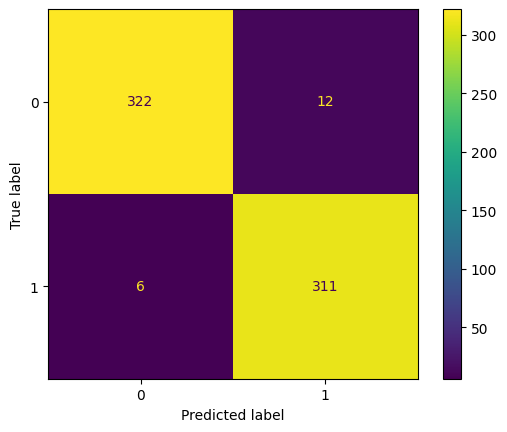

In [ ]:
cm = confusion_matrix(y_test, y_pred)
display=ConfusionMatrixDisplay(cm)
display.plot()
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.752071 to fit



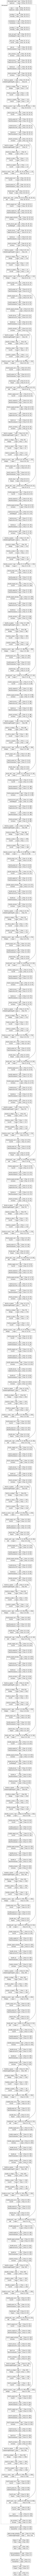

In [ ]:
tf.keras.utils.plot_model(model,
                          show_shapes=True,
                          expand_nested=True)

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    try:
      name = metric.replace("_"," ").capitalize()
      plt.plot(history.epoch, history.history[metric], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
      elif metric == 'auc':
        plt.ylim([0.8,1])
      else:
        plt.ylim([0,1])
      plt.legend()
      plt.show()
    except:
      pass

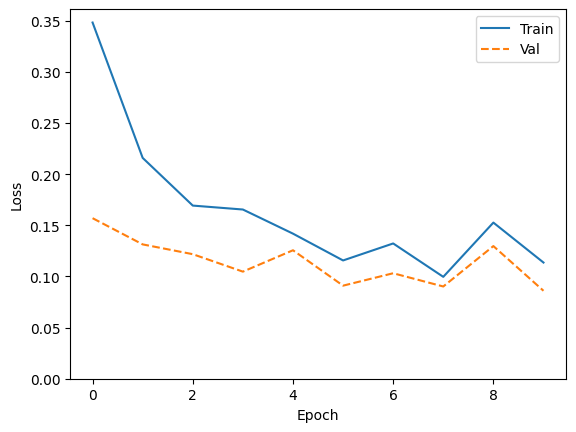

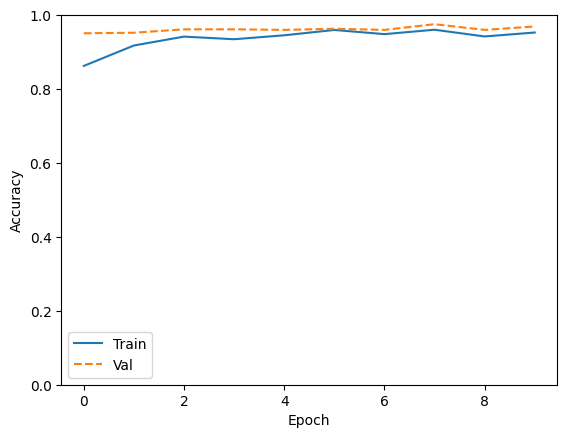

In [ ]:
plot_metrics(history)

1/1 [==============================] - 2s 2s/step
[[0.9995702]]
The uploaded X-ray image is: Tumor


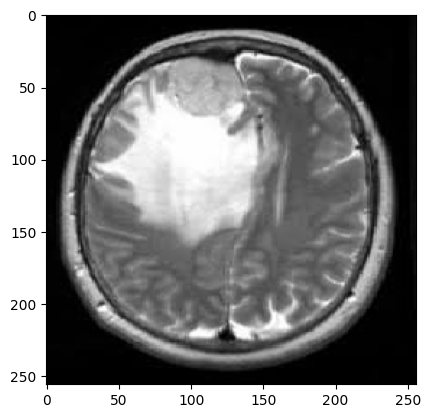

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from keras.models import load_model
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt

model = load_model('drive/MyDrive/Colab Notebooks/Tumor_Efficientnet/Tumor_Efficientnet.h5')

img = load_img('drive/MyDrive/Colab Notebooks/Tumor_Efficientnet/Tumor/pred/pred5.jpg',target_size=(256,256))

img_array  = img_to_array(img)
img_array = np.expand_dims(img_array,axis=0)
predictions = model.predict(img_array)
print(predictions)
if predictions[0] > 0.5:
    prediction_class = "Tumor"
else:
    prediction_class = "Healthy Brain"
plt.imshow(img)
print("The uploaded X-ray image is: " + prediction_class)